# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [0]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [0]:
import itertools
from collections import Counter
from string import punctuation

In [0]:
from razdel import tokenize

## Датасет Gazeta. Предварительная обработка

Загрузим датасет gazeta. Одновременно сделаем преобразование даты из строки

In [0]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [7]:
data_gazeta = pd.read_csv('../data/gazeta.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"',
                      error_bad_lines=False)

b'Skipping line 437258: expected 17 fields, saw 20\n'
b'Skipping line 591054: expected 17 fields, saw 20\n'
b'Skipping line 780302: expected 17 fields, saw 20\n'
b'Skipping line 793371: expected 17 fields, saw 20\n'
b'Skipping line 838172: expected 17 fields, saw 20\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# Проверим преобразование
data_gazeta.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors                object
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [9]:
data_gazeta.shape

(865847, 16)

In [10]:
# Так выглядет датасет
data_gazeta.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2008-11-21 15:19:14,https://www.gazeta.ru/news/business/2008/11/21...,-,Бизнес,NaN,Госдума сокращает срок действия ставки экспорт...,Госдума приняла сегодня в первом чтении и сраз...,-,-,-,-,-,-,-,-,-
1,2012-09-27 10:54:51,https://www.gazeta.ru/science/news/2012/09/27/...,-,Наука,NaN,Японские физики повторили синтез 113-го элемента,Японские ученые из физического центра RIKEN за...,-,-,-,-,-,-,-,-,-
2,2015-12-01 15:28:45,https://www.gazeta.ru/army/news/7957079.shtml,-,Армия,NaN,Times: Россия строит новую авиабазу в Сирии,Россия готовится расширить свою военную операц...,-,-,-,-,-,-,-,-,-
3,2013-04-18 16:42:06,https://www.gazeta.ru/travel/news/2013/04/18/n...,-,Новости,NaN,Власти Египта гарантируют безопасность российс...,Египет ждет российских туристов и гарантирует ...,-,-,-,-,-,-,-,-,-
4,2012-09-26 13:54:13,https://www.gazeta.ru/politics/news/2012/09/26...,-,Политика,NaN,Гордума Новочеркасска приняла отставку мэра го...,В Ростовской области депутаты гордумы Новочерк...,-,-,-,-,-,-,-,-,-


In [11]:
# Выясним в каким столбцах есть пустые данные
data_gazeta.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text           False
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

Как видим, в некоторых столбцах вместо значения Nan используется "-", их преобразованием займемся позже. А пока посмотрим строки, в которых пустые тексты новостей

In [12]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_gazeta['authors'].isnull().sum())
data_gazeta[data_gazeta['authors'].isnull()].head()

Кол-во строк с значением NaN в столбце "authors" =  801505


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2008-11-21 15:19:14,https://www.gazeta.ru/news/business/2008/11/21...,-,Бизнес,NaN,Госдума сокращает срок действия ставки экспорт...,Госдума приняла сегодня в первом чтении и сраз...,-,-,-,-,-,-,-,-,-
1,2012-09-27 10:54:51,https://www.gazeta.ru/science/news/2012/09/27/...,-,Наука,NaN,Японские физики повторили синтез 113-го элемента,Японские ученые из физического центра RIKEN за...,-,-,-,-,-,-,-,-,-
2,2015-12-01 15:28:45,https://www.gazeta.ru/army/news/7957079.shtml,-,Армия,NaN,Times: Россия строит новую авиабазу в Сирии,Россия готовится расширить свою военную операц...,-,-,-,-,-,-,-,-,-
3,2013-04-18 16:42:06,https://www.gazeta.ru/travel/news/2013/04/18/n...,-,Новости,NaN,Власти Египта гарантируют безопасность российс...,Египет ждет российских туристов и гарантирует ...,-,-,-,-,-,-,-,-,-
4,2012-09-26 13:54:13,https://www.gazeta.ru/politics/news/2012/09/26...,-,Политика,NaN,Гордума Новочеркасска приняла отставку мэра го...,В Ростовской области депутаты гордумы Новочерк...,-,-,-,-,-,-,-,-,-


In [13]:
print('authors: ',data_gazeta['authors'].unique())

authors:  [nan 'Александра Кошкина'
 'Анастасия Берсенева,Максим Солопов,Константин Новиков,Евгений Сафронов'
 ... 'Алина Распоповой' 'Анатолий Караваев,Юрий Воронцов'
 'Евгения Петрова (Сочи)']


Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [0]:
def analysis_columns(columns):
    for column in columns:
        if column not in ['url', 'date', 'topics', 'authors', 'title', 'text']:
            yield(print(str(column) + ':', data_gazeta[column].unique()))

In [15]:
data_columns = list(analysis_columns(data_gazeta.columns))

edition: ['-']
reposts_fb: ['-']
reposts_vk: ['-']
reposts_ok: ['-']
reposts_twi: ['-']
reposts_lj: ['-']
reposts_tg: ['-']
likes: ['-']
views: ['-']
comm_count: ['-']


In [16]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_gazeta.text.duplicated().sum())

Кол-во одинаковых текстов: 135


In [0]:
data_gazeta = data_gazeta.drop_duplicates(subset='text')

In [18]:
data_gazeta.shape

(865712, 16)

## EDA

### Анализ дат

In [19]:
print('Минимальная дата в датасете:', data_gazeta.date.min())
print('Максимальная дата в датасете:', data_gazeta.date.max())

Минимальная дата в датасете: 2007-03-03 11:17:10
Максимальная дата в датасете: 2019-05-23 23:45:48


#### Распределение количества новостей по месяцам

In [0]:
# Вынесем месяц и год новости в отдельные столбцы
data_gazeta['month'] = data_gazeta.date.apply(lambda x: x.month)
data_gazeta['year'] = data_gazeta.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data_gazeta.groupby(['year', 'month']).text.nunique().reset_index()

In [21]:
df.head()

,year,month,text
0,2007,3,245
1,2007,4,244
2,2007,7,1
3,2008,11,1
4,2009,2,1


In [0]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [0]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [0]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [25]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head()

,month_year,nunique_text
91,03-2017,13193
95,07-2017,12903
67,03-2015,12816
64,12-2014,12772
92,04-2017,12495


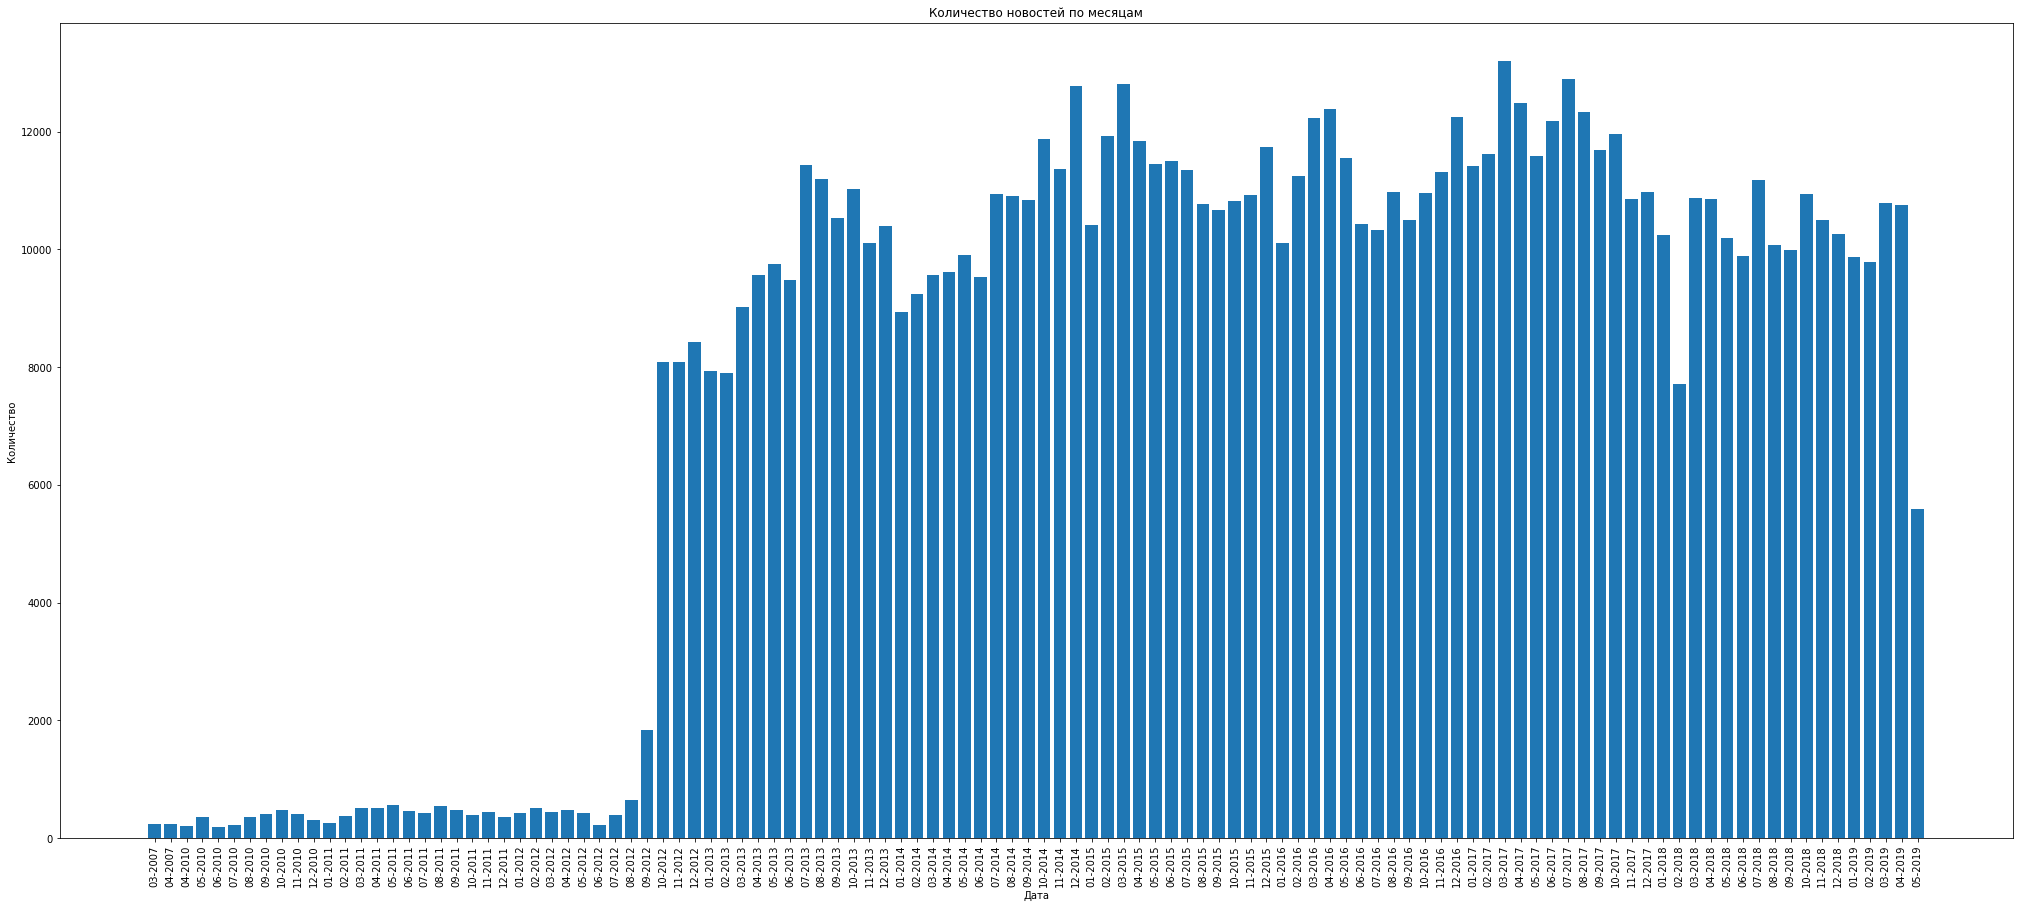

In [26]:
fig, ax = plt.subplots(figsize=(35, 15))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
ax.set_title('Количество новостей по месяцам')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
plt.show()

Создание словаря для анализа
В данной части блокнота будет подготовлен словарь из всего множества слов во всем датасете. Для каждой новости будет выполнена токенизация. Затем будет собран словарь из всех токенов, очистка от знаков препинания, и после данных процедур создается два списка - один без удаления стоп-слов, второй с удалением. Анализ проводится по частоте вхождений для каждого списка

In [0]:
def create_dictionary(text):
    for news in text:
        tokens = list(tokenize(news.lower()))
        yield([_.text for _ in tokens])

In [28]:
news_tokenize = list(create_dictionary(data_gazeta.text.values))
print('Done')

Done


In [0]:
# Соберем словарь из новостей для последующего анализа, без объединения повторяющихся слов
dictionary = list(itertools.chain.from_iterable(news_tokenize))

In [0]:
# Соберем значки препинания, часть возьмем из готовой библиотеки, часть добавим свои

In [0]:
punctuation = list(punctuation)

In [0]:
punctuation += ['«','»','—','n','»,','».', '–', '...']

In [0]:
garbage_words = ['nранее', 'nв', 'nпо', 'nтакже','u','n—', 'nn']

In [0]:
# Словарь без удаления стопслов
dictionary_with_stopwords = [item for item in dictionary if item not in punctuation]

In [0]:
dictionary_with_stopwords = [item for item in dictionary_with_stopwords if item not in garbage_words]

In [0]:
stopwords_01 = open('../nlp/preprocessing/stopwords.txt', 'r', encoding='UTF-8')
stopwords_01 = stopwords_01.read().split('\n')
stopwords_02 = open('../nlp/preprocessing/stopwords_02.txt', 'r', encoding='UTF-8')
stopwords_02 = stopwords_02.read().split('\n')

In [0]:
stopwords = stopwords_01 + stopwords_02

In [0]:
# Словарь после удаления стопслов
dictionary_without_stopwords = [item for item in dictionary_with_stopwords if item not in stopwords]

### Аналитика по словам

#### 20 самых популярных слов без удаления стопслов

In [38]:
Counter(dictionary_with_stopwords).most_common(20)

[('в', 5921442),
 ('и', 3073611),
 ('на', 2714042),
 ('что', 1714547),
 ('с', 1560556),
 ('не', 1357812),
 ('по', 1236926),
 ('nn', 659385),
 ('а', 564418),
 ('россии', 549331),
 ('о', 544778),
 ('за', 543531),
 ('из', 532436),
 ('к', 487355),
 ('он', 467770),
 ('как', 453032),
 ('это', 441027),
 ('но', 435006),
 ('для', 420739),
 ('у', 394216)]

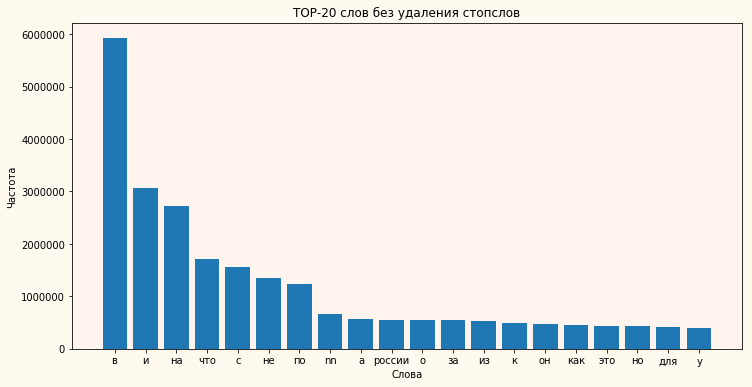

In [39]:
x = dict(Counter(dictionary_with_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_with_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

#### 20 самых популярных слов после удаления стопслов

In [40]:
Counter(dictionary_without_stopwords).most_common(20)

[('nn', 659385),
 ('россии', 549331),
 ('1', 306308),
 ('сообщает', 306067),
 ('заявил', 238584),
 ('2', 221286),
 ('сша', 214904),
 ('передает', 190968),
 ('0', 186018),
 ('странице', 172939),
 ('чемпионата', 166664),
 ('ru', 162568),
 ('новости', 160565),
 ('3', 159483),
 ('сообщалось', 158272),
 ('матче', 138890),
 ('словам', 135433),
 ('команды', 131364),
 ('сборной', 118473),
 ('другими', 118161)]

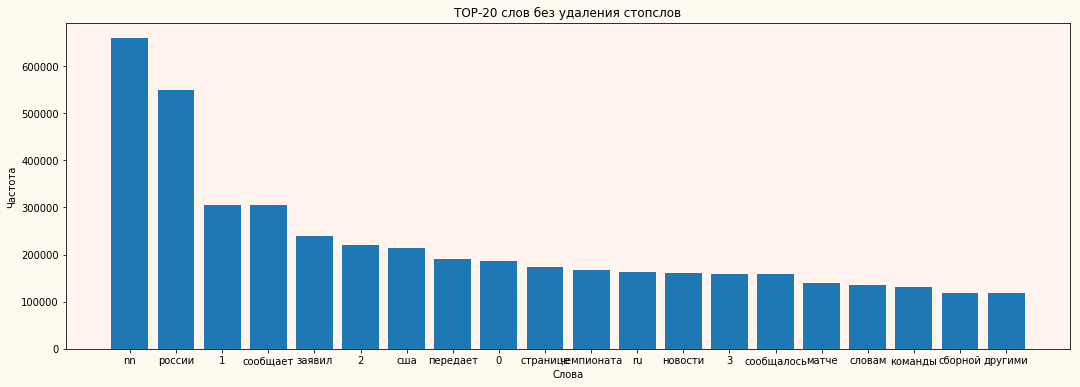

In [41]:
x = dict(Counter(dictionary_without_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_without_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

### Рубрики gazeta

In [42]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data_gazeta.topics.unique().shape)
data_gazeta['topics'].unique()

Количество рубрик =  (12,)


array(['Бизнес', 'Наука', 'Армия', 'Новости', 'Политика', 'Культура',
       'Спорт', 'Общество', 'Стиль', 'Технологии', 'Авто', 'Мнения'],
      dtype=object)

Все рубрики, с количеством новостей в каждой группе

In [43]:
data_gazeta.groupby('topics')['topics'].count()

topics
Авто           46469
Армия          25520
Бизнес        105365
Культура       42289
Мнения           890
Наука          17257
Новости        13246
Общество      163364
Политика      100213
Спорт         318845
Стиль          12875
Технологии     19379
Name: topics, dtype: int64